## Classificador de Intenções with DistilBERT Embbeding

In [1]:

import pandas as pd
import numpy as np

In [2]:
# ===== Dataset sintético =====

df = pd.read_csv('dataset_bancario_expandido.csv')
df.rename(columns={"frase": "texto", "label": "classe"}, inplace=True)
df.head()


,texto,classe
0,"Lançar cobrança para João no valor de R$ 3399,97",Cobrança
1,Gerar cobrança automática de R$ 3108,Cobrança
2,Cobrar R$ 4554 à vista amanhã,Cobrança
3,"Passe a cobrança de R$ 9,50 para o cliente",Cobrança
4,Cobrar R$ 541 à vista amanhã,Cobrança


In [3]:
df.shape

(2000, 2)

In [4]:
from sklearn.preprocessing import LabelEncoder

# Codificação das labels
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["classe"])
df.head()

,texto,classe,label
0,"Lançar cobrança para João no valor de R$ 3399,97",Cobrança,0
1,Gerar cobrança automática de R$ 3108,Cobrança,0
2,Cobrar R$ 4554 à vista amanhã,Cobrança,0
3,"Passe a cobrança de R$ 9,50 para o cliente",Cobrança,0
4,Cobrar R$ 541 à vista amanhã,Cobrança,0


In [5]:
df['texto_tratado'] = df['texto'].str.lower()

In [6]:
df[df['label'] == 1].head()

,texto,classe,label,texto_tratado
1000,Verificar saldo em conta conjunta,Consulta Saldo,1,verificar saldo em conta conjunta
1001,Consultar saldo atualizado,Consulta Saldo,1,consultar saldo atualizado
1002,Consultar saldo atualizado,Consulta Saldo,1,consultar saldo atualizado
1003,Consultar quanto tenho no banco,Consulta Saldo,1,consultar quanto tenho no banco
1004,Mostrar saldo bancário,Consulta Saldo,1,mostrar saldo bancário


In [7]:
df[df['label'] == 3].head()

,texto,classe,label,texto_tratado
500,"Pagar boleto no valor de R$ 449,52",Pagamento,3,"pagar boleto no valor de r$ 449,52"
501,"Transferir R$ 3953,23 para a conta poupança",Pagamento,3,"transferir r$ 3953,23 para a conta poupança"
502,"Transferir R$ 1308,25 para Maria",Pagamento,3,"transferir r$ 1308,25 para maria"
503,Realizar transferência de R$ 4727 para Pedro,Pagamento,3,realizar transferência de r$ 4727 para pedro
504,"Efetuar o pagamento da assinatura de R$ 4265,23",Pagamento,3,"efetuar o pagamento da assinatura de r$ 4265,23"


In [8]:
df[df['label'] == 0].head()

,texto,classe,label,texto_tratado
0,"Lançar cobrança para João no valor de R$ 3399,97",Cobrança,0,"lançar cobrança para joão no valor de r$ 3399,97"
1,Gerar cobrança automática de R$ 3108,Cobrança,0,gerar cobrança automática de r$ 3108
2,Cobrar R$ 4554 à vista amanhã,Cobrança,0,cobrar r$ 4554 à vista amanhã
3,"Passe a cobrança de R$ 9,50 para o cliente",Cobrança,0,"passe a cobrança de r$ 9,50 para o cliente"
4,Cobrar R$ 541 à vista amanhã,Cobrança,0,cobrar r$ 541 à vista amanhã


In [9]:
df[df['label'] == 2].head()

,texto,classe,label,texto_tratado
1500,Solicitar orçamento de compra,Outro,2,solicitar orçamento de compra
1501,Agendar revisão do carro,Outro,2,agendar revisão do carro
1502,Organizar documentos do escritório,Outro,2,organizar documentos do escritório
1503,Confirmar presença no evento,Outro,2,confirmar presença no evento
1504,Pedir orçamento para reforma,Outro,2,pedir orçamento para reforma


## DistilBERT

In [10]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("distilbert-base-multilingual-cased")

def get_embeddings(texts):
    return model.encode(texts, convert_to_numpy=True, show_progress_bar=True)


No sentence-transformers model found with name distilbert-base-multilingual-cased. Creating a new one with mean pooling.


In [11]:
X = get_embeddings(df["texto_tratado"].astype(str).tolist())
print(X.shape)  # (n amostras, 512)
y = df.label.values
print(y.shape)

print("Embeddings shape:", X.shape)

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

(2000, 768)
(2000,)
Embeddings shape: (2000, 768)


## Random Forest

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

classifier = RandomForestClassifier(n_estimators=10, random_state=0)
classifier.fit(X_train, y_train)

predict_labels = classifier.predict(X_test)

In [14]:
print("\n Precision \n", metrics.precision_score(y_test, predict_labels, average='macro'))


 Precision 
 1.0


In [15]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, predict_labels, target_names=label_encoder.classes_))

                precision    recall  f1-score   support

      Cobrança       1.00      1.00      1.00       157
Consulta Saldo       1.00      1.00      1.00       138
         Outro       1.00      1.00      1.00       160
     Pagamento       1.00      1.00      1.00       145

      accuracy                           1.00       600
     macro avg       1.00      1.00      1.00       600
  weighted avg       1.00      1.00      1.00       600



## Confusion Matrix

(<Figure size 500x500 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

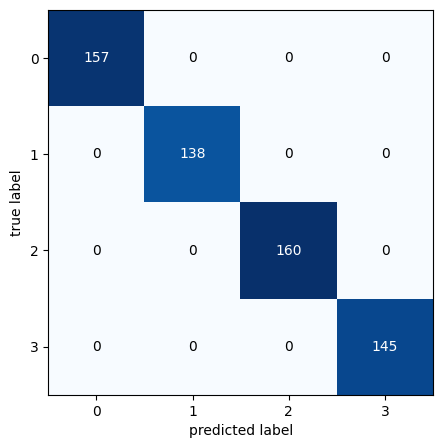

In [16]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm= confusion_matrix(y_test,predict_labels)
plot_confusion_matrix(cm, figsize=(5,5))

In [17]:
# ===== 8. Testando previsão =====
nova_frase = ["Pagar um boleto".lower()]
X_nova = get_embeddings(nova_frase)

pred = classifier.predict(X_nova)
print(pred)
# Obtém índice da classe com maior probabilidade
y_proba_novo = classifier.predict_proba(X_nova)

print("\nFrase:", nova_frase[0])
print("Classe prevista:", label_encoder.inverse_transform([pred]))
print("Confiança por classe:", y_proba_novo[0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[2]

Frase: pagar um boleto
Classe prevista: ['Outro']
Confiança por classe: [0.1 0.3 0.6 0. ]


/Users/felipemenezes/Codes/pythonEnvs/machine/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [18]:

# ==== Dataset de teste ====
dataset2 = [
    ("Pagar conta de luz", None),
    ("Trasferir R$5", None),
    ("Informe meu saldo", None),
    ("Cobra dez reais", None),
    ("me diga o meu saldo", None),
    ("passe um valor de R$50,00", None),
    ("transfirir R$3,99", None)
]
dfSample = pd.DataFrame(dataset2, columns=["texto", "classe_pred"])

dfSample['texto'] = dfSample['texto'].str.lower()

In [19]:
X_new = get_embeddings(dfSample["texto"].tolist())

preds = classifier.predict(X_new)
probs = classifier.predict_proba(X_new)

dfSample["classe_pred"] = label_encoder.inverse_transform(preds)
dfSample["probabilidade"] = probs.max(axis=1)
print(dfSample)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

                       texto     classe_pred  probabilidade
0         pagar conta de luz           Outro            0.4
1              trasferir r$5       Pagamento            0.6
2          informe meu saldo  Consulta Saldo            0.5
3            cobra dez reais        Cobrança            0.5
4        me diga o meu saldo  Consulta Saldo            0.6
5  passe um valor de r$50,00        Cobrança            0.8
6          transfirir r$3,99        Cobrança            0.5


## Extraindo Intenção Completa 

In [20]:
import re
# Funções regex
def extrair_valor(texto):
    match = re.search(r'[Rr]\$\s?([\d\.,]+)', texto)
    if match:
        valor = match.group(1).replace('.', '').replace(',', '.')
        return float(valor)
    return None

def extrair_parcelas(texto):
    match = re.search(r'(\d+)[xX]', texto)
    if match:
        return int(match.group(1))
    return None


In [21]:
dfSample["valor"] = dfSample["texto"].apply(
    lambda x: extrair_valor(x)
)

print(dfSample[['texto', 'classe_pred', 'probabilidade', 'valor' ]])

                       texto     classe_pred  probabilidade  valor
0         pagar conta de luz           Outro            0.4    NaN
1              trasferir r$5       Pagamento            0.6   5.00
2          informe meu saldo  Consulta Saldo            0.5    NaN
3            cobra dez reais        Cobrança            0.5    NaN
4        me diga o meu saldo  Consulta Saldo            0.6    NaN
5  passe um valor de r$50,00        Cobrança            0.8  50.00
6          transfirir r$3,99        Cobrança            0.5   3.99
